# Controle PI para o Controle de distância de um carro autônomo a um anteparo

Simulação 3D para o trabalho final de servomec III

In [410]:
# Pacotes
import pybullet as p
import time 
import pybullet_data
from math import pi
import math
from os.path import dirname, join as pjoin
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import random

In [411]:
# Abrir a interface
p.connect(p.GUI)

0

## Funções

In [412]:
# Dados do veículo:
rr = 0.05 # Raio da roda
D = 0.2 # Distância entre as rodas do mesmo eixo
L = 0.325 # Distância entre eixos 
B = 290/1000
f = 100/1000
l =  50/1000
A = l + f + L
phi_max = pi/6 # Ângulo de esterçamento máximo do veículo
dphi = 1 # Velocidade máxima do ângulo de esterçamento

In [413]:
def Coluna(Comprimento,x,y):
# Função que adiciona as paredes horizontais 
# x, y do centro da coluna
# th inclinação: 1 = eixo x, 0 = eixo y
    grossura = Comprimento 
    nb_bricks = 1
    brick_mass = 0.5
    
    # Parede 1
    brick_size = np.array([grossura, Comprimento, 0.2])
    brick_centers = np.zeros((nb_bricks, 3))
    brick_orns = np.zeros((nb_bricks, 4))
    brick_coll = p.createCollisionShape(p.GEOM_BOX,halfExtents=brick_size/2)
    
    # We use this array to store the reference of brick objects in pybullet world.
    bricks = np.zeros(1, dtype=np.int8)
    center_pos = np.array([x ,y , 0.1])
    brick_orns = np.array([0, 0, 0, 1]) # y
    bricks = p.createMultiBody(baseMass=brick_mass,
                              baseCollisionShapeIndex=brick_coll,
                              basePosition=center_pos,
                              baseOrientation=brick_orns)
    p.changeDynamics(bricks, -1, lateralFriction=0.1, restitution=0.1)

In [414]:
def position_orientation(model):
    '''
    Diante do modelo definido como nome do racecar, a função devolve a posição (xv,yv) e pose do robô () em relação
    ao referêncial entre eixos traseiro e no plano x,y
    '''
    position, orientation = p.getLinkState(car, 0)[:2] # Dados espaciais da referência
    # Posição
    xv = position[0]
    yv = position[1]
    
     # Inclinação
    w = orientation[3]
    # Pose do veículo
    thv = math.acos(w)*2 
    if orientation[2] != 0:
        thv = thv*orientation[2]/(abs(orientation[2]))
    return xv,yv,thv       

def real_phi (model_class):
    '''
    Função que diz o valor atual de phi do veículo, ideal para saber seu sinal de controle
    '''
    # Pegar os dados da classe
    model = model_class.model
    L = model_class.L
    D = model_class.D
    # ================================#
    phi1 = p.getJointState(model,6)[0] # Valor em radianos da roda direita dianteira
    if phi1 == 0:
        phi = 0
    else:
        phi = math.atan(L/(L/math.tan(phi1) - D/2))


In [415]:
# Classe para o carro
class class_car:
    def __init__(self,rr,D,L,B,f,l,phi_max,dphi_max,model,step):
        '''
        rr = Raio da roda
        D = Distância entre as rodas do mesmo eixo
        L = Distância entre eixos 
        B = Largura do veículo
        f = Distância entre a roda da frente e a frente do veículo
        l = Distância entre a roda de trás e a traseira do veículo
        A = Comprimento do veíclo
        phi_max = Ângulo de esterçamento máximo do veículo
        a = Aceleração inicial
        dphi_max = Velocidade máxima do ângulo de esterçamento
        V = Velocidade inicial
        phi = Ângulo de estarçamento inicial
        xv, yv = Posição inicial do veículo
        thv = Inclinação inicial do veículo
        step = step da simulação
        '''
        self.rr = rr
        self.D = D
        self.L = L
        self.B = B
        self.f = f
        self.l = l
        self.A = L + f + l
        self.phi_max = phi_max
        self.dphi_max = dphi_max
        self.model = model
        self.step = step
        # Histórico
        self.phi = [real_phi(self)]
        xv, yv, thv = position_orientation(self.model)
        self.xv = [xv]
        self.yv = [yv]
        self.thv = [thv]
    def Global (self):
        '''
        Atualiza todas as informações globais do carro
        '''
        xv, yv, thv = position_orientation(self.model)
        self.phi.append(real_phi(self))
        self.xv.append(xv)
        self.yv.append(yv)
        self.thv.append(thv)  
            
    def Velocidade_Phi (self, V, phi):
        '''
        Usa o veículo como classe
        '''
        # Função que define a velocidade e o ângulo de esterçamento de cada roda 
        # V = velocidade linear do veículo referenciando o modelo do tipo bicicleta, entre eixos traseiro;
        # phi = Ângulo de esterçamento da roda dianteira imaginária central;
        # D = Distância entre as rodas do mesmo eixo;
        # L = Distrância entre os eixos
        # r = Raio da roda do veículo
        # phi_max = Ângulo de esterçamento máximo
        # dphi = Velocidade do ângulo de esterçamento

        # Pegando os dados do veículo
        D = self.D
        L = self.L
        r = self.rr
        phi_max = self.phi_max
        dphi = self.dphi_max
        model = self.model
        # ================================== #
        # Limite do ângulo de esterçamento
        if abs(phi) > phi_max:
            phi = phi/(abs(phi))*phi_max 

        # Converter a velocidade V para rad/s
        V = V/r # rad/s
        if phi == 0:
            R = 99999999
        else:
            R = L/(math.tan(phi))
        phi_1 = math.atan(L/(R+D/2)) # Roda da direita
        phi_2 = math.atan(L/(R-D/2)) # Roda da esquerda

        vtd = V*(1+D/(2*R)) # 3
        vte = V*(1-D/(2*R)) # 2
        vfd = vtd/(math.cos(phi_1)) # 7
        vfe = vte/(math.cos(phi_2)) # 5


        # Torque
        T = 1

        # Velocidade
        # vfd
        p.setJointMotorControl2(model,7,p.VELOCITY_CONTROL,force=T,targetVelocity=vfd)

        # vfe
        p.setJointMotorControl2(model,5,p.VELOCITY_CONTROL,force=T,targetVelocity=vfe)

        # vtd
        p.setJointMotorControl2(model,3,p.VELOCITY_CONTROL,force=T,targetVelocity=vtd)

        # vte
        p.setJointMotorControl2(model,2,p.VELOCITY_CONTROL,force=T,targetVelocity=vte)

        # Ângulo de esterçamento
        # phi_1
        p.setJointMotorControl2(model,6, p.POSITION_CONTROL,maxVelocity=dphi,targetPosition = phi_1)
        # phi_2
        p.setJointMotorControl2(model,4, p.POSITION_CONTROL,maxVelocity=dphi,targetPosition = phi_2)

## Simulação

In [416]:
# Reset simulation
p.resetSimulation()
# Adicionar um plano
p.setAdditionalSearchPath(pybullet_data.getDataPath())
plane = p.loadURDF("plane.urdf")
car = p.loadURDF("racecar/racecar.urdf",[rr, 0, 0.001],[0,0,0,1],useFixedBase=0) # Posição
p.setGravity(0, 0, -9.81) # Gravidade 
step = 0.001 # 1 ms
p.setTimeStep(step) # time step
p.setRealTimeSimulation(0) # Retorna o tempo em zero

 # sensor 
q = 1 # Número de pontos do sensor
R = 10 # Tamanho do raio
hokuyo_joint= 0 # Número da junta que representa o sensor para o racecar
replaceLines = True
numRays= q # Número de raios do sensor 
rayFrom=[]
rayTo=[]
rayIds=[]
rayHitColor = [1,0,0] # Vermelho
rayMissColor = [0,1,0] # Verde
rayLen = R # Tamanho do raio do sensor 
rayStartLen = 0.1 # Distância do raio que começa os feixes dos sensores 
ang = math.pi # Abertura do sensor 
ang = ang*2 + 2*pi*0
for i in range (numRays):
    rayFrom.append([rayStartLen*(math.cos(i*ang/numRays - ang/2)), rayStartLen*(math.sin(i*ang/numRays - ang/2)),0])
    rayTo.append([rayLen*(math.cos(i*ang/numRays - ang/2)), rayLen*(math.sin(i*ang/numRays - ang/2)),0])
    if (replaceLines):
        rayIds.append(p.addUserDebugLine(rayFrom[i], rayTo[i], rayMissColor,parentObjectUniqueId=car, parentLinkIndex=hokuyo_joint ))
    else:
        rayIds.append(-1)

        
# Coluna 1
ta = 4
Coluna(ta,-ta/2,0) # (comprimento,x,y)

# Carro class
carc = class_car(rr,D,L,B,f,l,phi_max,dphi_max = dphi,model = car,step=step)


# ========================= Dados Controlador ==========================   




kp = 3# GANHO PROPORCIONAL
ki = 2# GANHO INTEGRAL




# =====================================================================
# Condições iniciais
I = 0
U = []
erro = []
dist = []

# Refência
Ref = 1 # metros

In [417]:
lastLidarTime = 0
#while True:
for _ in range(int(10/step)):
    # Sensor
    nowTime = time.time()
    nowControlTime = time.time()
    nowLidarTime = time.time()
    #if (1+1>0): 
    if (nowLidarTime-lastLidarTime>.3):
        numThreads=0
        results = p.rayTestBatch(rayFrom,rayTo,numThreads, parentObjectUniqueId=car, parentLinkIndex=hokuyo_joint)
        for i in range (numRays):
            hitObjectUid= results[i][0]
            hitFraction = results[i][2]
            hitPosition = results[i][3]
            if (hitFraction==1.):
                p.addUserDebugLine(rayFrom[i],rayTo[i], rayMissColor,replaceItemUniqueId=rayIds[i],parentObjectUniqueId=car, parentLinkIndex=hokuyo_joint)
            else:
                localHitTo = [rayFrom[i][0]+hitFraction*(rayTo[i][0]-rayFrom[i][0]),rayFrom[i][1]+hitFraction*(rayTo[i][1]-rayFrom[i][1]),rayFrom[i][2]+hitFraction*(rayTo[i][2]-rayFrom[i][2])]
                p.addUserDebugLine(rayFrom[i],localHitTo, rayHitColor,replaceItemUniqueId=rayIds[i],parentObjectUniqueId=car, parentLinkIndex=hokuyo_joint)
        lastLidarTime = nowLidarTime
    # Fim do sensor
    
    # Dado da distância 
    d = abs(results[0][3][0] - p.getLinkState(car, 8)[:2][0][0])
    dist.append(d)
    
    # erro
    e = Ref - d
    erro.append(e)
    
    # Controlador PI
    P = e*kp   # proporcional  
    I += ki*e*step
    u = (P + I)
    # Limite no sinal de controle
    if abs(u) > 1:
        u = 1*u/abs(u)
    U.append(u)
    
    # Aplica o sinal de controle Veículo
    carc.Velocidade_Phi(u,0)
    
    # Roda a simulação
    p.stepSimulation()
    carc.Global()

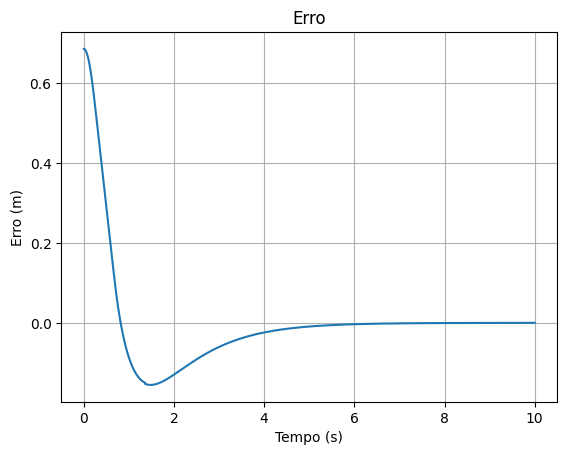

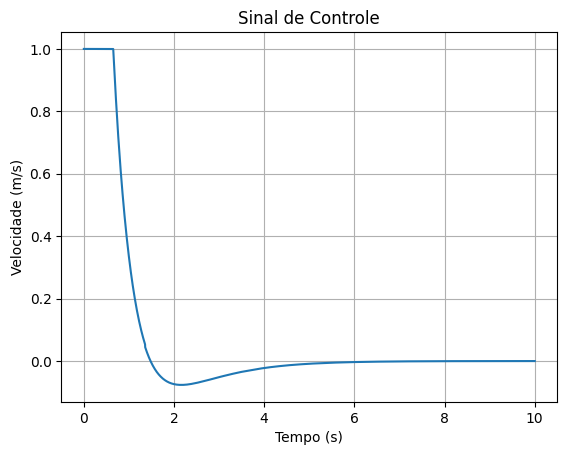

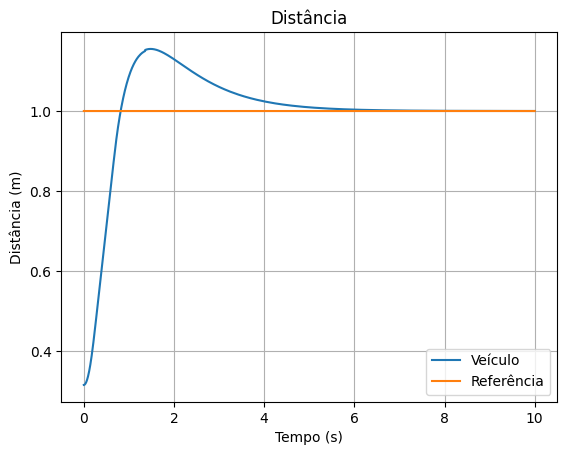

In [418]:
t = np.linspace(0,len(U)*step,len(U))

plt.plot(t,erro)
plt.grid()
plt.title('Erro')
plt.xlabel('Tempo (s)')
plt.ylabel('Erro (m)')
plt.show()


plt.plot(t,U)
plt.grid()
plt.title('Sinal de Controle')
plt.xlabel('Tempo (s)')
plt.ylabel('Velocidade (m/s)')
plt.show()

plt.plot(t,dist,label = 'Veículo')
plt.plot(t,Ref*np.ones(len(t)),label = 'Referência')
plt.title('Distância')
plt.xlabel('Tempo (s)')
plt.ylabel('Distância (m)')
plt.grid()
plt.legend(loc = 'lower right')
plt.show()

In [419]:
p.disconnect()

In [420]:
# overshoot
abs(min(erro)) * 100

15.528380205357095

In [422]:
step = 1
i = 0
for j in range(0, len(dist)):
    if dist[j] <= 1.05 and dist[j] >= 0.90:
        i = i + 1
        if i == step:
            print(f"Tempo acomodação {j/100}s {dist[j]}")

Tempo acomodação 6.89s 0.9003550391180479
